In [1]:
import sys
from pathlib import Path

# Detect project root (directory that contains both 'src/hansard' and 'notebooks')
current = Path.cwd()
project_root = current
for parent in [current] + list(current.parents):
    if (parent / 'src' / 'hansard').exists() and (parent / 'notebooks').exists():
        project_root = parent
        break

src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print(f"Project root: {project_root}")
print(f"Added to Python path: {src_path}")

import pandas as pd
import numpy as np


Project root: /Users/msawkar/Projects/hansard-nlp-explorer
Added to Python path: /Users/msawkar/Projects/hansard-nlp-explorer/src


## Configure input/output paths

Adjust these paths if your files are saved under different names.

In [2]:
from pathlib import Path

# Paths to inputs produced by the CLI scripts
flat_path = project_root / "outputs" / "trh/stereotypes_flattened.parquet"  # compare_stereotypes.py --output-flat
clusters_path = project_root / "outputs" / "trh/stereotype_clusters_labeled.parquet"  # summarize_stereotype_clusters.py --output

print(flat_path)
print(clusters_path)

/Users/msawkar/Projects/hansard-nlp-explorer/outputs/trh/stereotypes_flattened.parquet
/Users/msawkar/Projects/hansard-nlp-explorer/outputs/trh/stereotype_clusters_labeled.parquet


## Load flat stereotypes and cluster labels

In [3]:
df_flat = pd.read_parquet(flat_path)
df_clusters = pd.read_parquet(clusters_path)

print("Flat stereotypes:", df_flat.shape)
print("Cluster labels:", df_clusters.shape)
df_flat.head()

Flat stereotypes: (11268, 7)
Cluster labels: (30, 7)


,dataset,stereotype_text,dimension,polarity,confidence,count,cluster_id
0,hansard,A gender-balanced parliament would be better.,instrumental_effects,positive,0.8,1,4
1,hansard,A larger number of women voters than men voter...,social_order_stability,negative,0.9,1,20
2,hansard,A majority of women must assent to a change in...,competence_capacity,neutral,0.7,1,4
3,hansard,A single woman cannot represent all women's in...,equality,neutral,0.9,1,20
4,hansard,Abortion concerns only women.,equality,neutral,0.8,1,25


## Join stereotypes with cluster labels

Each row in `df_joined` is a stereotype instance with its dataset, cluster id, label, summary, and cluster type.

In [4]:
cols_clusters = ["cluster_id", "label", "summary", "cluster_type"]
df_clusters_small = df_clusters[cols_clusters].drop_duplicates()

df_joined = df_flat.merge(df_clusters_small, on="cluster_id", how="left")
print(df_joined.shape)
df_joined.head()

(11268, 10)


,dataset,stereotype_text,dimension,polarity,confidence,count,cluster_id,label,summary,cluster_type
0,hansard,A gender-balanced parliament would be better.,instrumental_effects,positive,0.8,1,4,suffrage/political agency,Focuses on women's right to vote and their cap...,both
1,hansard,A larger number of women voters than men voter...,social_order_stability,negative,0.9,1,20,politically incompetent/unfit,Asserts that women are inherently incapable of...,both
2,hansard,A majority of women must assent to a change in...,competence_capacity,neutral,0.7,1,4,suffrage/political agency,Focuses on women's right to vote and their cap...,both
3,hansard,A single woman cannot represent all women's in...,equality,neutral,0.9,1,20,politically incompetent/unfit,Asserts that women are inherently incapable of...,both
4,hansard,Abortion concerns only women.,equality,neutral,0.8,1,25,limited public/political agency,Depicts women as having restricted or no legit...,both


In [ ]:
# Quick sanity checks for different runs (e.g. different n_clusters).
print("flat_path:", flat_path)
print("clusters_path:", clusters_path)
print()
print("Unique cluster_id in flat:", df_flat["cluster_id"].nunique())
print("Unique cluster_id in labelled file:", df_clusters["cluster_id"].nunique())
print("Unique labels:", df_clusters["label"].nunique())
print()
missing_labels = df_joined["label"].isna().sum()
print("Instances without a cluster label:", missing_labels)
if missing_labels:
    display(df_joined[df_joined["label"].isna()].head())


## Quick EDA snapshots

Some quick counts to compare different runs (different clustering/label files).

In [ ]:
# Overall volume
print("Total stereotype instances:", len(df_joined))
print("Datasets:")
display(df_joined["dataset"].value_counts())
print("Cluster types:")
display(df_joined["cluster_type"].value_counts(dropna=False))

# Cluster sizes
cluster_sizes = df_joined.groupby("cluster_id")["stereotype_text"].size().describe()
print("\nCluster size summary (instances per cluster):")
display(cluster_sizes)

# Top labels by dataset (up to 10)
label_by_dataset = (
    df_joined.dropna(subset=["label"])
    .groupby(["label", "dataset"], dropna=False)["stereotype_text"]
    .size()
    .reset_index(name="n")
    .sort_values("n", ascending=False)
    .head(10)
)
print("\nTop labels by dataset (instances):")
display(label_by_dataset)

# Labels that are only in one dataset
label_presence = (
    df_joined.dropna(subset=["label"])
    .groupby(["label", "dataset"])["stereotype_text"]
    .size()
    .unstack(fill_value=0)
)
only_hansard_labels = label_presence[(label_presence.get("hansard", 0) > 0) & (label_presence.get("trh", 0) == 0)]
only_trh_labels = label_presence[(label_presence.get("trh", 0) > 0) & (label_presence.get("hansard", 0) == 0)]
print("\nLabels only in Hansard (counts by label):", len(only_hansard_labels))
print("Labels only in TRH (counts by label):", len(only_trh_labels))

# Per-cluster breakdown by dataset (first few)
cluster_by_dataset = (
    df_joined.groupby(["cluster_id", "dataset"])["stereotype_text"]
    .size()
    .reset_index(name="n")
    .sort_values(["cluster_id", "n"], ascending=[True, False])
)
print("\nPer-cluster counts by dataset (head):")
display(cluster_by_dataset.head(10))


## Aggregate by stereotype label and dataset

This shows how often each labeled stereotype appears in Hansard vs TRH, and whether it is shared (`cluster_type = both`) or dataset-specific.

In [5]:
df_for_agg = df_joined.copy()
if "count" not in df_for_agg.columns:
    df_for_agg["count"] = 1

summary = (
    df_for_agg.groupby(["label", "cluster_type", "dataset"], dropna=False)
    .agg(
        n_rows=("stereotype_text", "size"),
        n_unique_stereotypes=("stereotype_text", "nunique"),
        total_count=("count", "sum"),
    )
    .reset_index()
)

summary.sort_values(["cluster_type", "label", "dataset"]).head(20)

,label,cluster_type,dataset,n_rows,n_unique_stereotypes,total_count
1,comparative capabilities/equality,both,hansard,285,283,308
2,comparative capabilities/equality,both,trh,105,103,105
3,dehumanized/worthless,both,hansard,1,1,1
4,dehumanized/worthless,both,trh,553,491,553
5,domestic sphere/homemaker,both,hansard,10,10,10
6,domestic sphere/homemaker,both,trh,123,112,123
7,domestic/marital focus,both,hansard,297,294,313
8,domestic/marital focus,both,trh,41,40,41
10,gullible/easily manipulated,both,hansard,71,70,76
11,gullible/easily manipulated,both,trh,535,517,535


## Inspect examples for a particular stereotype label

Change `target_label` or `target_cluster_type` to drill into specific patterns.

In [6]:
target_label = summary["label"].dropna().unique()[0] if not summary.empty else None
target_cluster_type = "both"  # or "only_hansard", "only_trh"

if target_label is not None:
    examples = df_joined[
        (df_joined["label"] == target_label)
        & (df_joined["cluster_type"] == target_cluster_type)
    ][["dataset", "stereotype_text", "dimension", "polarity", "cluster_id"]].head(20)
    display(target_label, target_cluster_type, examples)
else:
    print("No labels available; check that the inputs are populated.")


'anti-feminist/anti-lesbian'

'both'

,dataset,stereotype_text,dimension,polarity,cluster_id


## Visualize similarities and differences

The plots below highlight how frequently each labeled stereotype appears in Hansard vs TRH, and how shared vs dataset-specific stereotypes are distributed.

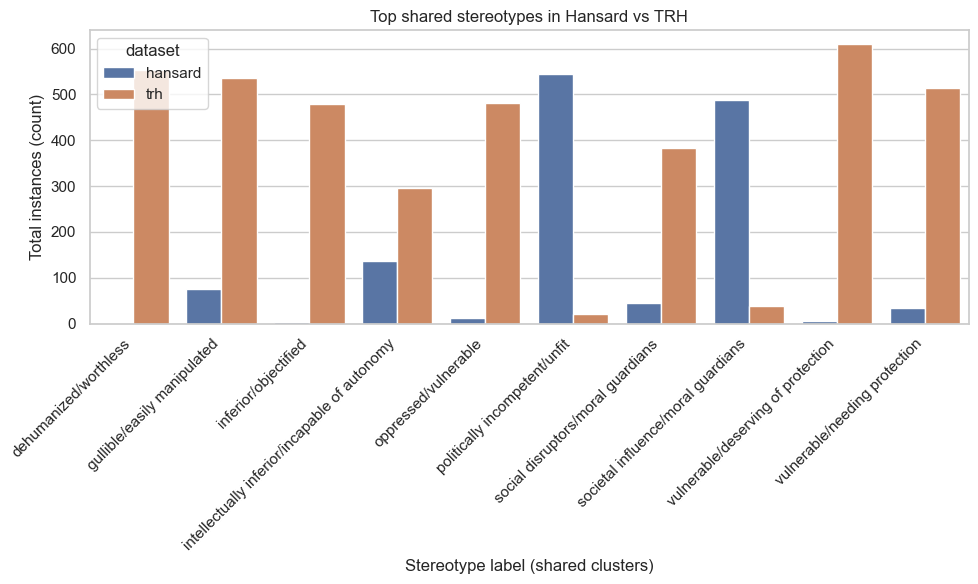

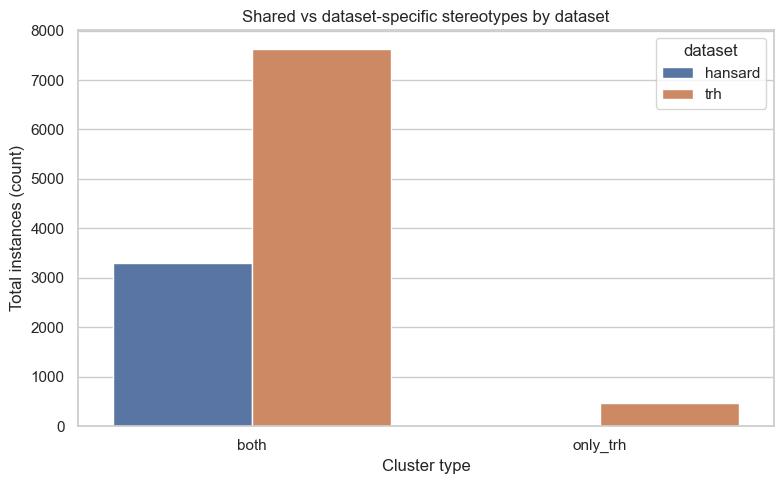

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1. Top shared stereotypes by dataset (cluster_type == 'both')
shared = summary[summary["cluster_type"] == "both"].copy()
if not shared.empty:
    # Take top N labels by total_count across both datasets
    top_n = 10
    shared_total = (
        shared.groupby("label", dropna=False)["total_count"].sum().reset_index()
        .sort_values("total_count", ascending=False)
        .head(top_n)
    )
    shared_top_labels = shared_total["label"].tolist()
    shared_plot = shared[shared["label"].isin(shared_top_labels)]

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=shared_plot,
        x="label",
        y="total_count",
        hue="dataset",
    )
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Total instances (count)")
    plt.xlabel("Stereotype label (shared clusters)")
    plt.title("Top shared stereotypes in Hansard vs TRH")
    plt.tight_layout()
    plt.show()
else:
    print("No shared (cluster_type='both') stereotypes found in summary.")

# 2. Distribution of stereotypes by cluster_type and dataset
cluster_counts = (
    summary.groupby(["cluster_type", "dataset"], dropna=False)["total_count"]
    .sum()
    .reset_index()
)
if not cluster_counts.empty:
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=cluster_counts,
        x="cluster_type",
        y="total_count",
        hue="dataset",
    )
    plt.ylabel("Total instances (count)")
    plt.xlabel("Cluster type")
    plt.title("Shared vs dataset-specific stereotypes by dataset")
    plt.tight_layout()
    plt.show()
else:
    print("No data available to plot cluster_type by dataset.")


## Dimension and polarity distribution by dataset

These plots show how stereotype **dimensions** (e.g. emotion, morality, political competence) and **polarities** (positive/negative/ambivalent/neutral) are distributed across Hansard and TRH.

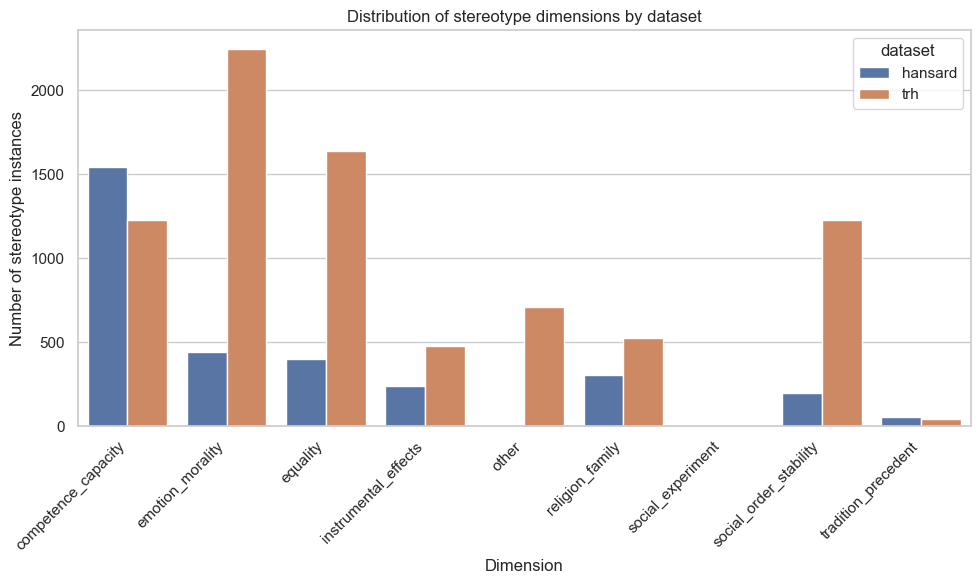

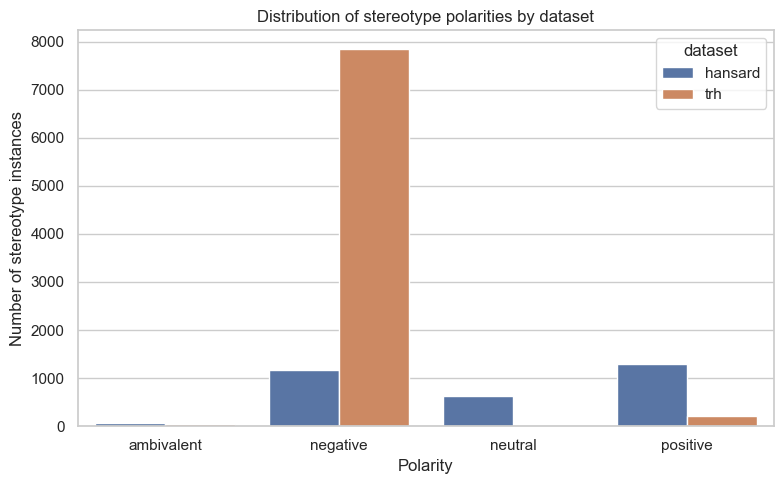

In [8]:
# Count by dimension and dataset
dim_counts = (
    df_joined.groupby(["dimension", "dataset"], dropna=False)["stereotype_text"]
    .size()
    .reset_index(name="n")
)

if not dim_counts.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=dim_counts,
        x="dimension",
        y="n",
        hue="dataset",
    )
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Number of stereotype instances")
    plt.xlabel("Dimension")
    plt.title("Distribution of stereotype dimensions by dataset")
    plt.tight_layout()
    plt.show()
else:
    print("No data available for dimension counts.")

# Count by polarity and dataset
pol_counts = (
    df_joined.groupby(["polarity", "dataset"], dropna=False)["stereotype_text"]
    .size()
    .reset_index(name="n")
)

if not pol_counts.empty:
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=pol_counts,
        x="polarity",
        y="n",
        hue="dataset",
    )
    plt.xticks(rotation=0)
    plt.ylabel("Number of stereotype instances")
    plt.xlabel("Polarity")
    plt.title("Distribution of stereotype polarities by dataset")
    plt.tight_layout()
    plt.show()
else:
    print("No data available for polarity counts.")


## Confidence distribution by dataset

This shows how the confidence scores of extracted stereotypes differ between Hansard and TRH.

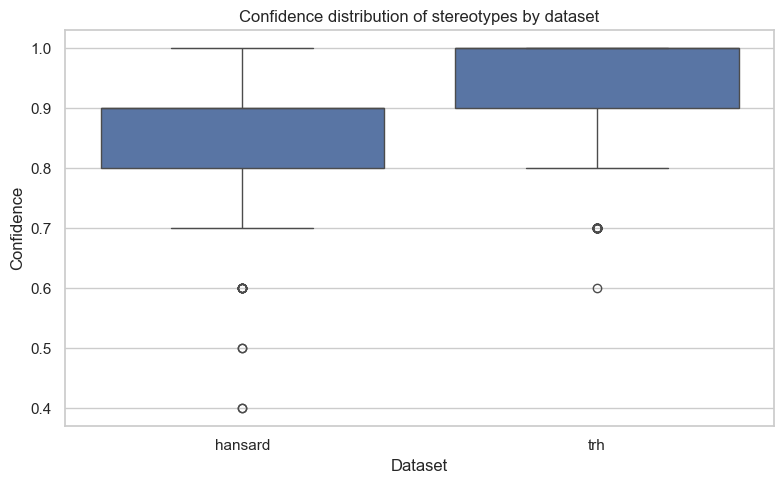

In [9]:
if "confidence" in df_joined.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(
        data=df_joined,
        x="dataset",
        y="confidence",
    )
    plt.ylabel("Confidence")
    plt.xlabel("Dataset")
    plt.title("Confidence distribution of stereotypes by dataset")
    plt.tight_layout()
    plt.show()
else:
    print("Column 'confidence' not found in df_joined.")
